<a href="https://colab.research.google.com/github/hongyuw0427/Final-Year-Project/blob/main/FYP_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Loading dataset...
Initial shape: (47692, 2)
Columns: ['tweet_text', 'cyberbullying_type']

Dropping exact duplicates...
Removed 43 duplicate rows. New shape: (47649, 2)

Checking nulls in important columns:
0 null tweet_text values

Total rows that would be dropped (clean_text becomes empty): 498

Sample of dropped rows:
                                        tweet_text
              @Jord_Is_Dead http://t.co/UsQInYW5Gn
                       @KamilaaRudenko how are u ?
                                     #simpleasthat
         #face #hope #bullying http://t.co/taLCQMj
              @ANDAASONSAN https://t.co/dtjOHnRNhQ
                                                :D
        @Vrais66 And these. http://t.co/V3cf0aGlcp
                      No u. http://t.co/zOr0eWahSS
                               @kylieminogue @muse
             #chevape #paprikash #wogfood #MKR2015
                        No. http://t.co/ljHm8Wd27r
                            http://t.co/O6tdUczw5z
             

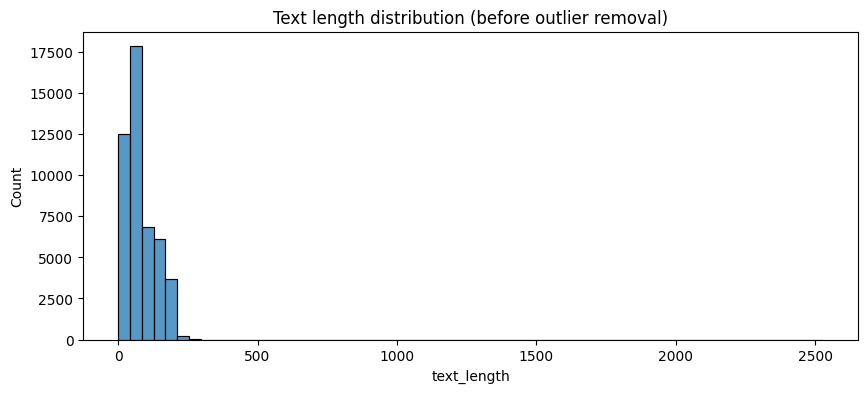


Computing sentence embeddings using: all-MiniLM-L6-v2


Batches:   0%|          | 0/737 [00:00<?, ?it/s]

Embeddings shape: (47151, 384)

Reducing embeddings with PCA -> 50 dims
Explained variance (sum): 0.5384223

Running IsolationForest (contamination=0.03)
Detected outliers: 1415 / 47151 (3.001%)

Sample outlier entries (first 10):
                                                                                                                                    tweet_text                                                                                clean_text  text_length
    RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##GoogleÇeviriciTopluluğuKürtçeyideE…                                                   rt turkish state killed child last year           39
#Kerala RTE will lead to shutting down of 'Badal' schools in backward areas &amp; parents will mostly not allow them to join far away schools. rte lead shutting badal school backward area amp parent mostly allow join far away school           89
                               

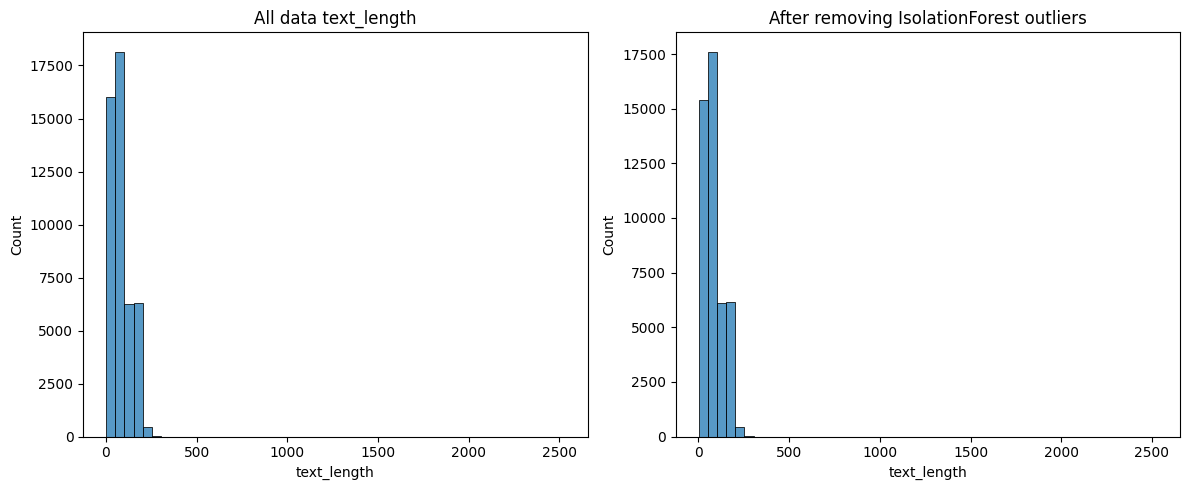

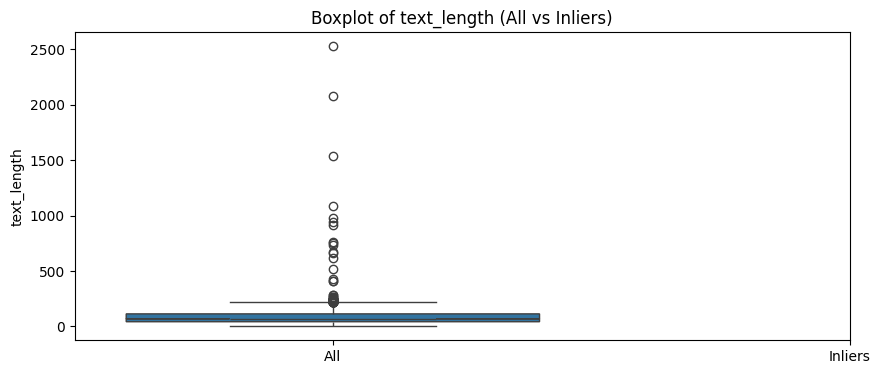


Shape before outlier removal: (47151, 5)
Shape after outlier removal: (45736, 5)

Descriptive stats (text_length) after outlier removal:
count    45736.000000
mean        81.429968
std         55.322114
min          1.000000
25%         42.000000
50%         69.000000
75%        113.000000
max       2528.000000
Name: text_length, dtype: float64

Saving cleaned dataset (inliers) to: /content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets_cleaned.csv

SUMMARY:
original_rows: 47151
outliers_removed: 1415
remaining_rows: 45736
contamination_used: 0.03
embedding_model: all-MiniLM-L6-v2
pca_dim: 50

Finished. You can inspect /mnt/data/df_no_outliers.csv and adjust ISO_CONTAMINATION or PCA_DIM if needed.


In [ ]:
# corrected_fyp_outlier_pipeline.py
# Run this in the same environment where /mnt/data/cyberbullying_tweets.csv is available.

import os
import re
import string
import math
import warnings
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# embeddings and sklearn
try:
    from sentence_transformers import SentenceTransformer
except Exception:
    # If running in a fresh environment (Colab), install
    import sys
    !{sys.executable} -m pip install -q sentence-transformers
    from sentence_transformers import SentenceTransformer

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suppress warnings for clarity
warnings.filterwarnings("ignore")

# ---------------------------
# Configuration
# ---------------------------
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets.csv"
OUTPUT_CLEAN_CSV = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets_cleaned.csv"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"   # compact, fast and good for semantic similarity
PCA_DIM = 50            # set to None to skip PCA; 50 is usually safe for 384-d embeddings
ISO_CONTAMINATION = 0.03  # 3% default; change to 0.01-0.05 as experiment
RANDOM_STATE = 42

# ---------------------------
# Utility / Prep
# ---------------------------
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def basic_clean(text: str) -> str:
    """Basic cleaning: remove URLs, mentions, hashtags, punctuation, digits, extra spaces."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', ' ', text)          # remove mentions
    text = re.sub(r'#\w+', ' ', text)          # remove hashtags (the words)
    text = text.encode('ascii', errors='ignore').decode()  # remove weird unicode
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', ' ', text)           # remove digits
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_text_function(text: str) -> str:
    text = basic_clean(text)
    tokens = text.split()
    tokens = [tok for tok in tokens if tok not in stop_words and len(tok) > 1]
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(tokens)

# ---------------------------
# Load dataset
# ---------------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Place your CSV at that path.")

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# If your tweet text column is named differently, adapt:
if "tweet_text" not in df.columns:
    # try common alternatives
    for alt in ["text", "tweet", "content", "message"]:
        if alt in df.columns:
            df.rename(columns={alt: "tweet_text"}, inplace=True)
            print(f"Renamed column '{alt}' -> 'tweet_text'")
            break
    else:
        raise KeyError("Couldn't find a 'tweet_text' column. Please ensure your CSV contains the tweet text column.")

# ---------------------------
# Basic cleaning & dedupe
# ---------------------------
print("\nDropping exact duplicates...")
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. New shape: {df.shape}")

print("\nChecking nulls in important columns:")
print(df['tweet_text'].isnull().sum(), "null tweet_text values")

# fill and ensure string format
df['tweet_text'] = df['tweet_text'].fillna("").astype(str)

# Generate clean_text
df['clean_text'] = df['tweet_text'].apply(clean_text_function)

# ---------------------------
# Identify rows that would be dropped
# ---------------------------
dropped_rows = df[df['clean_text'].str.strip() == ""]

print(f"\nTotal rows that would be dropped (clean_text becomes empty): {dropped_rows.shape[0]}")

# Print sample of 20 rows
print("\nSample of dropped rows:")
print(dropped_rows[['tweet_text']].head(20).to_string(index=False))

# Save all dropped rows for manual inspection
dropped_rows.to_csv(
    "/content/drive/MyDrive/Colab Notebooks/FYP/dropped_rows_before_outlier_cleaning.csv",
    index=False
)
print("\nAll dropped rows saved to: dropped_rows_before_outlier_cleaning.csv")

# ---------------------------
# Now drop empty rows and continue cleaning
# ---------------------------
empty_before = df.shape[0]
df = df[df['clean_text'].str.strip() != ""].copy()
empty_after = df.shape[0]
print(f"\nDropped {empty_before - empty_after} rows with empty clean_text.")
print("Shape after cleaning:", df.shape)


# ---------------------------
# Quick EDA: class distribution & text length
# ---------------------------
if 'cyberbullying_type' in df.columns:
    print("\nClass distribution (cyberbullying_type):")
    print(df['cyberbullying_type'].value_counts())

df['text_length'] = df['clean_text'].apply(len)
print("\nText length stats:")
print(df['text_length'].describe())

# visualize text length before outlier removal
plt.figure(figsize=(10,4))
sns.histplot(df['text_length'], bins=60)
plt.title("Text length distribution (before outlier removal)")
plt.xlabel("text_length")
plt.show()

# ---------------------------
# Embeddings (semantic vectors)
# ---------------------------
print("\nComputing sentence embeddings using:", EMBEDDING_MODEL)
model = SentenceTransformer(EMBEDDING_MODEL)

# For speed & memory, encode in batches
sentences = df['clean_text'].tolist()
embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True)
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)

# ---------------------------
# Optional: scale + PCA to reduce dims for IsolationForest
# ---------------------------
if PCA_DIM is not None and PCA_DIM > 0 and embeddings.shape[1] > PCA_DIM:
    print(f"\nReducing embeddings with PCA -> {PCA_DIM} dims")
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(embeddings)
    pca = PCA(n_components=PCA_DIM, random_state=RANDOM_STATE)
    emb_reduced = pca.fit_transform(emb_scaled)
    print("Explained variance (sum):", np.sum(pca.explained_variance_ratio_))
else:
    emb_reduced = embeddings

# ---------------------------
# IsolationForest on embeddings
# ---------------------------
print(f"\nRunning IsolationForest (contamination={ISO_CONTAMINATION})")
iso = IsolationForest(n_estimators=200, contamination=ISO_CONTAMINATION, random_state=RANDOM_STATE, n_jobs=-1)
iso_labels = iso.fit_predict(emb_reduced)   # 1 => inlier, -1 => outlier
df['isof_label'] = iso_labels
n_outliers = (iso_labels == -1).sum()
n_total = len(iso_labels)
print(f"Detected outliers: {n_outliers} / {n_total} ({n_outliers/n_total:.3%})")

# ---------------------------
# Inspect representative outliers (optional)
# ---------------------------
print("\nSample outlier entries (first 10):")
print(df.loc[df['isof_label'] == -1, ['tweet_text', 'clean_text', 'text_length']].head(10).to_string(index=False))

# show some inliers for comparison
print("\nSample inlier entries (first 10):")
print(df.loc[df['isof_label'] == 1, ['tweet_text', 'clean_text', 'text_length']].head(10).to_string(index=False))

# ---------------------------
# Compare text_length distributions before/after
# ---------------------------
df_inliers = df[df['isof_label'] == 1].copy()
df_outliers = df[df['isof_label'] == -1].copy()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['text_length'], bins=50)
plt.title("All data text_length")
plt.subplot(1,2,2)
sns.histplot(df_inliers['text_length'], bins=50)
plt.title("After removing IsolationForest outliers")
plt.tight_layout()
plt.show()

# boxplots
plt.figure(figsize=(10,4))
sns.boxplot(data=[df['text_length'], df_inliers['text_length']], notch=True)
plt.xticks([0,1], ['All', 'Inliers'])
plt.ylabel('text_length')
plt.title('Boxplot of text_length (All vs Inliers)')
plt.show()

# ---------------------------
# Decide: remove outliers or keep flagged set
# ---------------------------
# Here we create df_no_outliers but we keep original df as reference.
df_no_outliers = df_inliers.copy()
print("\nShape before outlier removal:", df.shape)
print("Shape after outlier removal:", df_no_outliers.shape)

# descriptive stats after removal
print("\nDescriptive stats (text_length) after outlier removal:")
print(df_no_outliers['text_length'].describe())

# ---------------------------
# Save cleaned dataset
# ---------------------------
print(f"\nSaving cleaned dataset (inliers) to: {OUTPUT_CLEAN_CSV}")
df_no_outliers.to_csv(OUTPUT_CLEAN_CSV, index=False)

# ---------------------------
# Summary output for report
# ---------------------------
summary = {
    "original_rows": n_total,
    "outliers_removed": n_outliers,
    "remaining_rows": df_no_outliers.shape[0],
    "contamination_used": ISO_CONTAMINATION,
    "embedding_model": EMBEDDING_MODEL,
    "pca_dim": PCA_DIM if (PCA_DIM and embeddings.shape[1] > PCA_DIM) else None
}
print("\nSUMMARY:")
for k,v in summary.items():
    print(f"{k}: {v}")

print("\nFinished. You can inspect /mnt/data/df_no_outliers.csv and adjust ISO_CONTAMINATION or PCA_DIM if needed.")


In [ ]:
# Count per class
print("\nOutliers per class:")
print(df[df['isof_label'] == -1]['cyberbullying_type'].value_counts())

print("\nInliers per class:")
print(df[df['isof_label'] == 1]['cyberbullying_type'].value_counts())

# Total rows per class
total = df['cyberbullying_type'].value_counts()

# Outliers per class
outliers = df[df['isof_label'] == -1]['cyberbullying_type'].value_counts()

# Inliers per class
inliers = df[df['isof_label'] == 1]['cyberbullying_type'].value_counts()

# Combine
summary = pd.DataFrame({
    "Total": total,
    "Outliers": outliers,
    "Inliers": inliers,
})

summary["Outlier%"] = (summary["Outliers"] / summary["Total"]) * 100
summary = summary.fillna(0).astype({"Outliers": int, "Inliers": int})

print("\nOutlier summary per class:")
print(summary)


Outliers per class:
cyberbullying_type
not_cyberbullying      402
gender                 358
other_cyberbullying    273
religion               242
ethnicity              106
age                     34
Name: count, dtype: int64

Inliers per class:
cyberbullying_type
age                    7955
ethnicity              7846
religion               7754
gender                 7538
not_cyberbullying      7357
other_cyberbullying    7286
Name: count, dtype: int64

Outlier summary per class:
                     Total  Outliers  Inliers  Outlier%
cyberbullying_type                                     
age                   7989        34     7955  0.425585
ethnicity             7952       106     7846  1.332998
gender                7896       358     7538  4.533941
not_cyberbullying     7759       402     7357  5.181080
other_cyberbullying   7559       273     7286  3.611589
religion              7996       242     7754  3.026513


# Base model without feature extraction and hyperparameter tuning
* Logistic Regression
* Random Forest
* SVM
* deep learning (LSTM)





In [ ]:
# ===============================
# BASELINE EXPERIMENTS (NO FEATURES / NO TUNING)
# Logistic Regression / Random Forest / SVM / LSTM
# CountVectorizer + Tokenizer only
# ===============================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, callbacks

# ----------------------------
# Configuration
# ----------------------------
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets_cleaned.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

SPLITS = [(0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Tokenizer + LSTM params
MAX_WORDS = 20000
MAX_LEN = 100
EMBED_DIM = 64
LSTM_UNITS = 64
EPOCHS = 4
BATCH_SIZE = 128

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)

texts = df["clean_text"].astype(str).tolist()
labels = df["cyberbullying_type"].astype(str).tolist()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
label_names = le.classes_
num_classes = len(label_names)

# Binarized labels for ROC-AUC
Y_bin_full = label_binarize(y, classes=range(num_classes))

# ----------------------------
# CountVectorizer baseline
# ----------------------------
vectorizer = CountVectorizer()
vectorizer.fit(texts)

# ----------------------------
# Tokenizer for LSTM
# ----------------------------
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# ----------------------------
# Utility: Save confusion matrix
# ----------------------------
def save_confusion(y_true, y_pred, classes, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(filename)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.close()

# ----------------------------
# Train + Evaluate Models
# ----------------------------
results = []

for train_frac, test_frac in SPLITS:

    print(f"\n====================")
    print(f"Train {int(train_frac*100)}%  Test {int(test_frac*100)}%")
    print(f"====================")

    # split
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        texts, y,
        test_size=test_frac,
        random_state=SEED,
        stratify=y
    )

    # CountVectorizer transform
    X_train_cv = vectorizer.transform(X_train_text)
    X_test_cv = vectorizer.transform(X_test_text)

    # Prepare for ROC-AUC
    Y_test_bin = label_binarize(y_test, classes=range(num_classes))

    # ===========================================
    # Logistic Regression
    # ===========================================
    print("Training Logistic Regression...")
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_cv, y_train)
    y_pred = lr.predict(X_test_cv)
    y_proba = lr.predict_proba(X_test_cv)

    results.append({
        "model": "LogisticRegression",
        "train_frac": train_frac,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": roc_auc_score(Y_test_bin, y_proba, average="macro", multi_class="ovr")
    })

    save_confusion(y_test, y_pred, label_names, f"cm_LR_{int(train_frac*100)}.png")

    # ===========================================
    # Random Forest
    # ===========================================
    print("Training Random Forest...")
    rf = RandomForestClassifier()
    rf.fit(X_train_cv, y_train)
    y_pred = rf.predict(X_test_cv)
    y_proba = rf.predict_proba(X_test_cv)

    results.append({
        "model": "RandomForest",
        "train_frac": train_frac,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": roc_auc_score(Y_test_bin, y_proba, average="macro", multi_class="ovr")
    })

    save_confusion(y_test, y_pred, label_names, f"cm_RF_{int(train_frac*100)}.png")

    # ===========================================
    # SVM
    # ===========================================
    print("Training SVM...")
    svm = SVC(kernel="linear", probability=True)
    svm.fit(X_train_cv, y_train)
    y_pred = svm.predict(X_test_cv)
    y_proba = svm.predict_proba(X_test_cv)

    results.append({
        "model": "SVM",
        "train_frac": train_frac,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": roc_auc_score(Y_test_bin, y_proba, average="macro", multi_class="ovr")
    })

    save_confusion(y_test, y_pred, label_names, f"cm_SVM_{int(train_frac*100)}.png")

    # ===========================================
    # LSTM BASELINE
    # ===========================================
    print("Training LSTM...")
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)

    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

    model = models.Sequential([
        layers.Embedding(MAX_WORDS, EMBED_DIM, input_length=MAX_LEN),
        layers.LSTM(LSTM_UNITS),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    es = callbacks.EarlyStopping(patience=1, restore_best_weights=True)

    model.fit(
        X_train_pad, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=1
    )

    y_proba = model.predict(X_test_pad)
    y_pred = np.argmax(y_proba, axis=1)

    results.append({
        "model": "LSTM",
        "train_frac": train_frac,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": roc_auc_score(Y_test_bin, y_proba, average="macro", multi_class="ovr")
    })

    save_confusion(y_test, y_pred, label_names, f"cm_LSTM_{int(train_frac*100)}.png")

# ----------------------------
# Save Results
# ----------------------------
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(OUTPUT_DIR, "baseline_results.csv"), index=False)

print("\n======================")
print("BASELINE RESULTS DONE")
print("======================")
print(results_df)


Loaded dataset: (45736, 5)

Train 90%  Test 10%
Training Logistic Regression...
Training Random Forest...
Training SVM...
Training LSTM...
Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step - accuracy: 0.5565 - loss: 1.0794 - val_accuracy: 0.8040 - val_loss: 0.4288
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 45s 154ms/step - accuracy: 0.8309 - loss: 0.4000 - val_accuracy: 0.8300 - val_loss: 0.4192
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 46s 160ms/step - accuracy: 0.8804 - loss: 0.2943 - val_accuracy: 0.8164 - val_loss: 0.4833
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Train 80%  Test 20%
Training Logistic Regression...
Training Random Forest...
Training SVM...
Training LSTM...
Epoch 1/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 158ms/step - accuracy: 0.5506 - loss: 1.1205 - val_accuracy: 0.7896 - val_loss: 0.4561
Epoch 2/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.8324 - loss: 0.3913 - val_accuracy: 0.8207 - val_loss: 0.4447
Epoch 3/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - a

# BiLSTM

Loaded dataset: (45736, 5)
Loaded existing baseline results: (20, 7)

Running BiLSTM Baseline 90 / 10

Epoch 1/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 112s 363ms/step - accuracy: 0.5609 - loss: 1.0723 - val_accuracy: 0.7872 - val_loss: 0.4445
Epoch 2/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 106s 365ms/step - accuracy: 0.8206 - loss: 0.4120 - val_accuracy: 0.8127 - val_loss: 0.4303
Epoch 3/4
290/290 ━━━━━━━━━━━━━━━━━━━━ 100s 346ms/step - accuracy: 0.8739 - loss: 0.3035 - val_accuracy: 0.8164 - val_loss: 0.4579
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


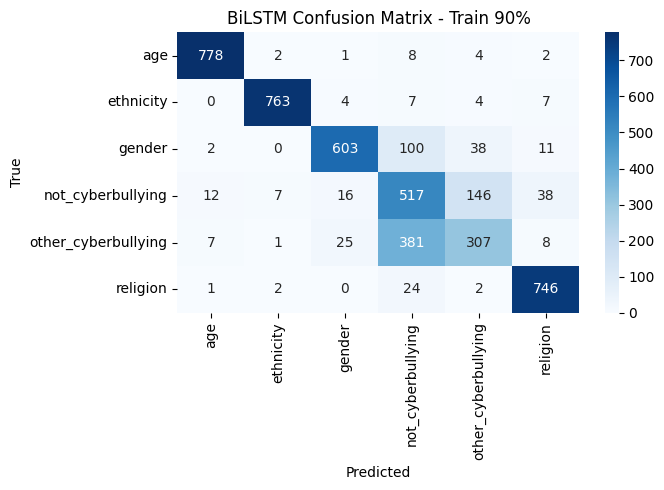

✔ Confusion matrix saved to:
/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results/bilstm_cm_90.png


Running BiLSTM Baseline 80 / 20

Epoch 1/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 100s 366ms/step - accuracy: 0.5000 - loss: 1.1683 - val_accuracy: 0.7855 - val_loss: 0.4832
Epoch 2/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 92s 358ms/step - accuracy: 0.8100 - loss: 0.4129 - val_accuracy: 0.8166 - val_loss: 0.4399
Epoch 3/4
258/258 ━━━━━━━━━━━━━━━━━━━━ 142s 357ms/step - accuracy: 0.8695 - loss: 0.3110 - val_accuracy: 0.8101 - val_loss: 0.4707
286/286 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


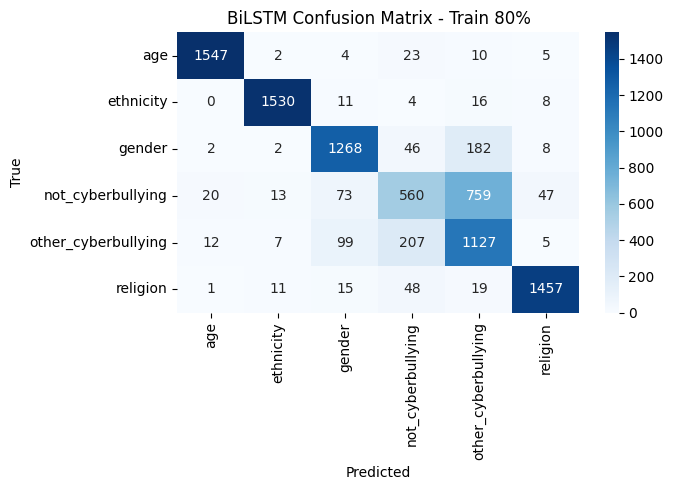

✔ Confusion matrix saved to:
/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results/bilstm_cm_80.png


Running BiLSTM Baseline 70 / 30

Epoch 1/4
226/226 ━━━━━━━━━━━━━━━━━━━━ 83s 344ms/step - accuracy: 0.5164 - loss: 1.1616 - val_accuracy: 0.7892 - val_loss: 0.4685
Epoch 2/4
226/226 ━━━━━━━━━━━━━━━━━━━━ 82s 345ms/step - accuracy: 0.8091 - loss: 0.4280 - val_accuracy: 0.8095 - val_loss: 0.4431
Epoch 3/4
226/226 ━━━━━━━━━━━━━━━━━━━━ 79s 351ms/step - accuracy: 0.8642 - loss: 0.3372 - val_accuracy: 0.8129 - val_loss: 0.4813
429/429 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step


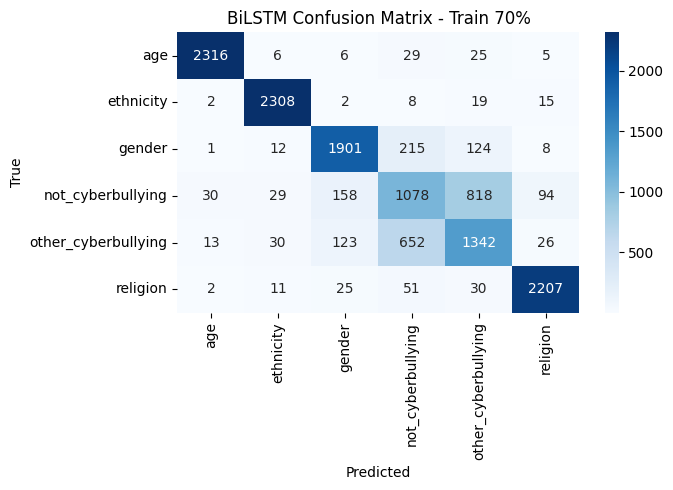

✔ Confusion matrix saved to:
/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results/bilstm_cm_70.png


Running BiLSTM Baseline 60 / 40

Epoch 1/4
193/193 ━━━━━━━━━━━━━━━━━━━━ 72s 345ms/step - accuracy: 0.5235 - loss: 1.1923 - val_accuracy: 0.7927 - val_loss: 0.4702
Epoch 2/4
193/193 ━━━━━━━━━━━━━━━━━━━━ 69s 356ms/step - accuracy: 0.8173 - loss: 0.4314 - val_accuracy: 0.7825 - val_loss: 0.4862
572/572 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step


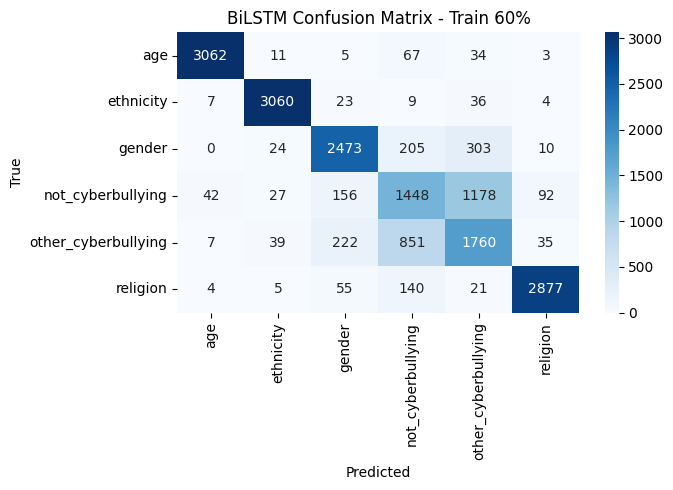

✔ Confusion matrix saved to:
/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results/bilstm_cm_60.png


   BiLSTM BASELINE FINISHED 
   Results + confusion matrices saved
   Updated baseline_results.csv



,model,train_frac,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.9,0.816353,0.821982,0.811229,0.815493,0.964155
1,RandomForest,0.9,0.808045,0.811429,0.802539,0.804882,0.950014
2,SVM,0.9,0.804766,0.807642,0.799443,0.802764,0.961735
3,LSTM,0.9,0.823131,0.824355,0.818067,0.820555,0.967283
4,LogisticRegression,0.8,0.815807,0.818477,0.810489,0.813875,0.964345
5,RandomForest,0.8,0.809685,0.809395,0.804012,0.805262,0.951141
6,SVM,0.8,0.807062,0.807253,0.801611,0.803980,0.962550
7,LSTM,0.8,0.823896,0.830264,0.819041,0.815998,0.966478
8,LogisticRegression,0.7,0.817069,0.818769,0.811747,0.814745,0.964567
9,RandomForest,0.7,0.810218,0.808375,0.804558,0.804795,0.952416


In [4]:
# =============================================
# BASELINE BiLSTM with Confusion Matrix (4 splits)
# Appends results into existing baseline CSV
# Saves confusion matrices automatically
# =============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# ----------------------------
# Configuration
# ----------------------------
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/cyberbullying_tweets_cleaned.csv"
BASELINE_PATH = "/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results/baseline_results.csv"
SAVE_CM_DIR = "/content/drive/MyDrive/Colab Notebooks/FYP/baseline_results"

MAX_WORDS = 20000
MAX_LEN = 100
EMBED_DIM = 64
LSTM_UNITS = 64
EPOCHS = 4
BATCH_SIZE = 128
SPLITS = [(0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4)]
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

os.makedirs(SAVE_CM_DIR, exist_ok=True)


# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)

texts = df["clean_text"].astype(str).tolist()
labels = df["cyberbullying_type"].astype(str).tolist()

# Label encoding
le = LabelEncoder()
y = le.fit_transform(labels)
label_names = le.classes_
num_classes = len(label_names)

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)


# ----------------------------
# Load existing baseline results
# ----------------------------
print("Loaded existing baseline results:", pd.read_csv(BASELINE_PATH).shape)


# ----------------------------
# Save + Show Confusion Matrix
# ----------------------------
def save_and_show_confusion_matrix(y_true, y_pred, classes, title, filename):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d",
                cmap="Blues",
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()

    save_path = f"{SAVE_CM_DIR}/{filename}.png"
    plt.savefig(save_path)
    plt.show()

    print(f"✔ Confusion matrix saved to:\n{save_path}\n")


# ----------------------------
# RUN BILSTM FOR ALL SPLITS
# ----------------------------
bilstm_results = []

for train_frac, test_frac in SPLITS:

    print(f"\n======================================")
    print(f"Running BiLSTM Baseline {int(train_frac*100)} / {int(test_frac*100)}")
    print("======================================\n")

    # Split
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        texts, y, test_size=test_frac, random_state=SEED, stratify=y
    )

    # Sequence conversion
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
    X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

    # ----------------------------
    # Build BiLSTM Model
    # ----------------------------
    model = models.Sequential([
        layers.Embedding(MAX_WORDS, EMBED_DIM),
        layers.Bidirectional(layers.LSTM(LSTM_UNITS)),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    es = callbacks.EarlyStopping(patience=1, restore_best_weights=True)

    model.fit(
        X_train_pad, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=1
    )

    # Predictions
    y_proba = model.predict(X_test_pad)
    y_pred = np.argmax(y_proba, axis=1)

    # Save + show confusion matrix
    title = f"BiLSTM Confusion Matrix - Train {int(train_frac*100)}%"
    filename = f"bilstm_cm_{int(train_frac*100)}"
    save_and_show_confusion_matrix(y_test, y_pred, label_names, title, filename)

    # ROC-AUC (binarized)
    y_test_bin = label_binarize(y_test, classes=range(num_classes))

    bilstm_results.append({
        "model": "BiLSTM",
        "train_frac": train_frac,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="macro"),
        "recall": recall_score(y_test, y_pred, average="macro"),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": roc_auc_score(
            y_test_bin, y_proba, average="macro", multi_class="ovr"
        )
    })


# ----------------------------
# Save into baseline results
# ----------------------------
bilstm_df = pd.DataFrame(bilstm_results)

old_df = pd.read_csv(BASELINE_PATH)
merged_df = pd.concat([old_df, bilstm_df], ignore_index=True)

merged_df.to_csv(BASELINE_PATH, index=False)

print("\n===================================")
print("   BiLSTM BASELINE FINISHED ")
print("   Results + confusion matrices saved")
print("   Updated baseline_results.csv")
print("===================================\n")

merged_df
